In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from lcc import MODEL_DIR
from lcc.dataset import LCCDataset, get_transforms
from lcc.models.UNet import UNet
from lcc.models.unet_model import UNet as UNet2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(
    in_channels=4,
    out_channels=10,
).to(device)
model.load_state_dict(torch.load(MODEL_DIR / 'UNet_cross_entropy_loss_weighted.pth'))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of trainable parameters: {params}')

Number of trainable parameters: 31038794


In [4]:
import torchsummary

torchsummary.summary(model, (4, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─DoubleConv: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Sequential: 3-1              [-1, 64, 256, 256]        39,424
├─MaxPool2d: 1-1                         [-1, 64, 128, 128]        --
├─ModuleList: 1                          []                        --
|    └─DoubleConv: 2-2                   [-1, 128, 128, 128]       --
|    |    └─Sequential: 3-2              [-1, 128, 128, 128]       221,696
├─MaxPool2d: 1-2                         [-1, 128, 64, 64]         --
├─ModuleList: 1                          []                        --
|    └─DoubleConv: 2-3                   [-1, 256, 64, 64]         --
|    |    └─Sequential: 3-3              [-1, 256, 64, 64]         885,760
├─MaxPool2d: 1-3                         [-1, 256, 32, 32]         --
├─ModuleList: 1                          []                        --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─DoubleConv: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Sequential: 3-1              [-1, 64, 256, 256]        39,424
├─MaxPool2d: 1-1                         [-1, 64, 128, 128]        --
├─ModuleList: 1                          []                        --
|    └─DoubleConv: 2-2                   [-1, 128, 128, 128]       --
|    |    └─Sequential: 3-2              [-1, 128, 128, 128]       221,696
├─MaxPool2d: 1-2                         [-1, 128, 64, 64]         --
├─ModuleList: 1                          []                        --
|    └─DoubleConv: 2-3                   [-1, 256, 64, 64]         --
|    |    └─Sequential: 3-3              [-1, 256, 64, 64]         885,760
├─MaxPool2d: 1-3                         [-1, 256, 32, 32]         --
├─ModuleList: 1                          []                        --
|

In [3]:
dataset = LCCDataset(transform=get_transforms(), train=False)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [4]:
idx = np.random.randint(0, len(dataset))
image, mask = dataset[idx]['image'], dataset[idx]['mask']
output = model(image.permute(2, 0, 1).unsqueeze(0).to(device))
print(output.shape)

torch.Size([1, 10, 256, 256])


TypeError: Invalid shape (1,) for image data

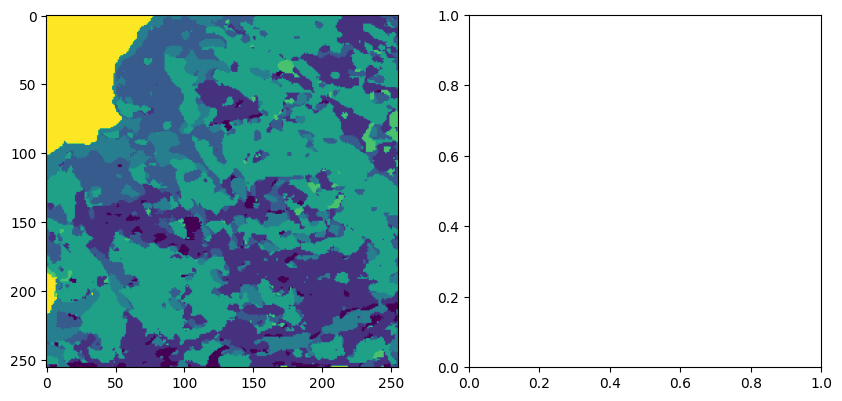

In [5]:
tmp_out = output.argmax(dim=1).squeeze().cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(tmp_out)
ax[1].imshow(mask)
plt.axis('off')

In [8]:
all_out = []
N_CLASSES = 10
all_logits = []
with torch.no_grad():
    model.eval()
    for _, batch in (pbar:=tqdm(enumerate(dataloader), total=len(dataloader))):
        image = batch['image']
        image = image.permute(0, 3, 1, 2)
        output = model(image.to(device))
        all_logits.append(output.cpu().numpy())
        tmp_out = output.argmax(dim=1)
        for i in range(tmp_out.shape[0]):
            distrib_out = torch.zeros(N_CLASSES).to(device)
            tmp_class, tmp_n = torch.unique(tmp_out[i], return_counts=True)
            distrib_out[tmp_class] = tmp_n.float()
            distrib_out[:2] = 0
            if not(distrib_out.sum() == 0):
                distrib_out = distrib_out / distrib_out.sum()
            all_out.append(distrib_out.cpu().numpy())
all_out = np.array(all_out)

 45%|████▌     | 143/316 [01:26<01:45,  1.65it/s]


KeyboardInterrupt: 

In [7]:
HEADER = "no_data,clouds,artificial,cultivated,broadleaf,coniferous,herbaceous,natural,snow,water"

df = pd.DataFrame(all_out, columns=HEADER.split(','))
df.insert(0, 'sample_id', dataset.test_images_csv)
print(df.head())
df.to_csv('submission_Unet_cross_entropy_loss_weighted.csv', index=False)

   sample_id  no_data  clouds  artificial  cultivated  broadleaf  coniferous  \
0      10087      0.0     0.0    0.020630    0.272064   0.189194    0.008453   
1      10088      0.0     0.0    0.010742    0.448181   0.168839    0.007309   
2      10089      0.0     0.0    0.083939    0.284302   0.205444    0.037796   
3      10090      0.0     0.0    0.020721    0.031891   0.444412    0.193878   
4      10091      0.0     0.0    0.047440    0.393234   0.173828    0.033585   

   herbaceous   natural  snow     water  
0    0.491913  0.010132   0.0  0.007614  
1    0.360596  0.004333   0.0  0.000000  
2    0.374054  0.002991   0.0  0.011475  
3    0.304825  0.001053   0.0  0.003220  
4    0.346817  0.002808   0.0  0.002289  


In [13]:
output.argmax(1)

torch.Size([3, 256, 256])

In [9]:
all_logits = np.concatenate(all_logits)

<BarContainer object of 10 artists>

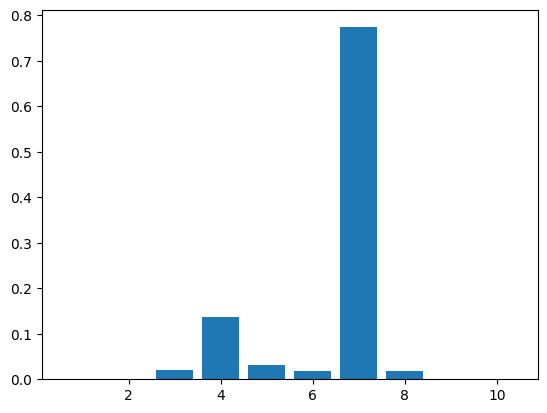

In [25]:
plt.bar(np.array(range(10))+1, torch.nn.functional.softmax(torch.from_numpy(all_logits[0]), dim=0)[:,0,0])

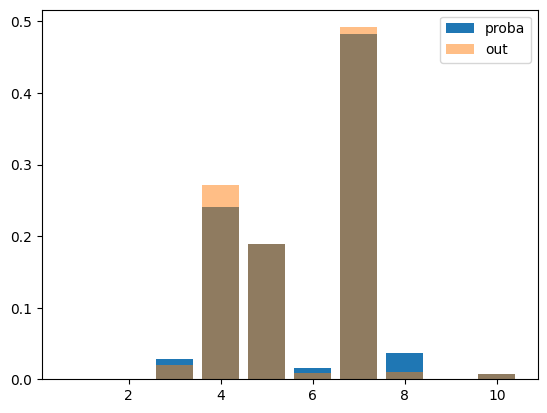

In [33]:
plt.bar(np.array(range(10))+1,torch.nn.functional.softmax(torch.from_numpy(all_logits[0]), dim=0).mean(2).mean(1), label='proba')
plt.bar(np.array(range(10))+1, all_out[0], label='out', alpha=.5)
plt.legend()

In [3]:
train_ds = LCCDataset(transform=get_transforms())


In [12]:
test_out = model(train_ds[0]['image'].permute(2,0,1).to(device).unsqueeze(0))
true_mask = train_ds[0]['mask']
test_out_b = test_out.argmax(1)

In [13]:
distrib_out = torch.zeros(10).to(device)
tmp_class, tmp_n = torch.unique(test_out_b, return_counts=True)
distrib_out[tmp_class] = tmp_n.float()
distrib_out[:2] = 0
if not(distrib_out.sum() == 0):
    distrib_out = distrib_out / distrib_out.sum()


In [17]:
distrib_true = torch.zeros(10)
tmp_class, tmp_n = torch.unique(true_mask, return_counts=True)
distrib_true[tmp_class] = tmp_n.float()
distrib_true[:2] = 0
if not(distrib_true.sum() == 0):
    distrib_true = distrib_true / distrib_true.sum()


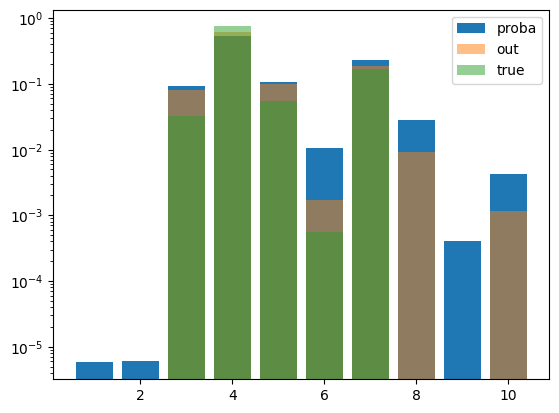

In [27]:
plt.bar(np.array(range(10))+1,torch.nn.functional.softmax(test_out.squeeze(), dim=0).mean(2).mean(1).cpu().detach().numpy(), label='proba')
plt.bar(np.array(range(10))+1, distrib_out.cpu().detach().numpy(), label='out', alpha=.5)
plt.bar(np.array(range(10))+1, distrib_true.numpy(), label='true', alpha=.5)
plt.semilogy()
plt.legend()


In [25]:
def kl_div_discrete(y_true, y_pred, eps=1e-8):
    res = 0
    for i in range(2,len(y_pred)):
        res += (y_true[i]+eps)*np.log((y_true[i]+eps)/(y_pred[i]+eps))
    return res

kl_div_discrete(distrib_true.numpy(),torch.nn.functional.softmax(test_out.squeeze(), dim=0).mean(2).mean(1).cpu().detach().numpy(), )

0.12881501864264486

In [26]:
kl_div_discrete(distrib_true.numpy(), distrib_out.cpu().numpy())

0.0559443749526814